<a href="https://colab.research.google.com/github/ndronen/econdata/blob/main/notebooks/Corruption_and_GDP_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
#@title Mount Google Drive for saving plots
DRIVE_PATH = "/content/gdrive"
NOTEBOOK_PATH = f"{DRIVE_PATH}/My Drive/Colab Notebooks"
drive.mount(DRIVE_PATH)

Mounted at /content/gdrive


In [3]:
#@title Set Pandas options
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option('mode.chained_assignment', 'raise')

In [4]:
#@title Data access functions
GDP_COUNTRY_CODE = "Country Code"
GDP_COUNTRY_NAME = "Country Name"
CORRUPTION_COUNTRY_CODE = "ISO3"
CORRUPTION_COUNTRY_NAME = "Country / Territory"
CORRUPTION_INDEX = "CPI score 2021"


def get_gdp_country_codes(gdp_df):
    codes = gdp_df[GDP_COUNTRY_CODE]
    return codes


def get_corruption_country_codes(corruption_df):
    codes = corruption_df[CORRUPTION_COUNTRY_CODE]
    return codes


def get_common_codes(gdp_codes, corruption_codes):
    common_codes = set(gdp_codes).intersection(corruption_codes)
    return common_codes


def get_common_code_subset(common_codes, df, code_column_name):
    mask = df[code_column_name].apply(lambda code: code in common_codes)
    df = df[mask]
    df = df.sort_values(code_column_name)
    return df


def join_dataframes(gdp_df, corruption_df):
    gdp_df.reset_index(inplace=True)
    corruption_df.reset_index(inplace=True)
    joined_df = pd.concat((gdp_df, corruption_df), axis=1)
    return joined_df


def only_countries_with_gdp_in_year(df, year):
    has_gdp = ~df[year].isnull()
    return df[has_gdp]


def get_bottom_countries_by_region(df, sort_column):
    bottom = []
    for region, grp in df.groupby("Region"):
        bottom.append(grp.sort_values(sort_column).head(1))
    df = pd.concat(bottom)
    return df


def get_top_countries_by_region(df, sort_column):
    bottom = []
    for region, grp in df.groupby("Region"):
        bottom.append(grp.sort_values(sort_column).tail(1))
    df = pd.concat(bottom)
    return df

In [5]:
#@title Plotting functions
def plot_cpi_against_gdp_for_year(df, year, xmax=None):
    df_year = only_countries_with_gdp_in_year(joined_df, year)
    fig, ax = plt.subplots(1, figsize=(12, 4))
    ax.scatter(df_year[year], df_year[CORRUPTION_INDEX])
    ax.set_xlabel(f"GDP in {year}")
    ax.set_ylabel("Corruption (CPI)")
    if xmax is not None:
        ax.set_xlim((0, xmax))


def plot_cpi_against_change_in_gdp_per_capita(
    df, start_year, end_year, xmax=None, annotate_extremes=False
):
    def get_codes(year):
        return only_countries_with_gdp_in_year(df, year)[GDP_COUNTRY_CODE]

    start_year_codes = get_codes(start_year)
    end_year_codes = get_codes(end_year)
    common_codes = get_common_codes(start_year_codes, end_year_codes)

    mask = df[GDP_COUNTRY_CODE].apply(lambda code: code in common_codes)
    df_start_end = df[mask].copy()
    change_in_gdp_per_capita = df_start_end[end_year] - df_start_end[start_year]
    year_range_column = f"{start_year}-{end_year}"
    df_start_end.loc[:, year_range_column] = change_in_gdp_per_capita

    fig, ax = plt.subplots(1, figsize=(10, 6))
    cmap = plt.get_cmap("tab20")
    markers = ["+", "D", "o", "s", ">", "X"]
    for i, (region, grp) in enumerate(df_start_end.groupby("Region")):
        ax.scatter(
            grp[year_range_column],
            grp[CORRUPTION_INDEX],
            label=region,
            color=cmap(i),
            marker=markers[i]
        )

    if annotate_extremes:
        def _annotate_extremes(df):
            for code, grp in df.groupby(GDP_COUNTRY_CODE):
                x = grp[year_range_column].values[0]
                y = grp[CORRUPTION_INDEX].values[0]
                ax.text(x + x*.01, y + y*.01, grp[GDP_COUNTRY_NAME].values[0])

        # Label countries with greatest or least growth in GDP per capita.
        df_top = get_top_countries_by_region(df_start_end, year_range_column)
        _annotate_extremes(df_top)
        df_least_corrupt = get_top_countries_by_region(df_start_end, CORRUPTION_INDEX)
        _annotate_extremes(df_least_corrupt)
            
    ax.set_xlabel(f"Change in GDP per capita from {start_year} to {end_year}")
    ax.set_ylabel("Corruption (CPI) in 2021")
    ax.legend(title="Region", loc='lower right')

    if xmax is not None:
        ax.set_xlim((0, xmax))

    fig.savefig(
        f"{NOTEBOOK_PATH}/change-in-gdp-per-capita-{start_year}-to-{end_year}.png",
        dpi=300
    )

    return df_start_end, year_range_column

In [6]:
#@title Load data
base_url = "https://raw.githubusercontent.com/ndronen/econdata/5b3a94e4def5b21051eac7e5e65ed56ddf6397e4/data"
corruption_url = f"{base_url}/corruption-perceptions-index-2021-transparency-org.csv"
gdp_url = f"{base_url}/gdp-per-capita-of-countries-in-current-usd-world-bank.csv"
corruption_df = pd.read_csv(corruption_url)
gdp_df = pd.read_csv(gdp_url)

In [7]:
#@title Preprocess and join the GDP and corruption data.
gdp_country_codes = get_gdp_country_codes(gdp_df)
corruption_country_codes = get_corruption_country_codes(corruption_df)
common_codes = get_common_codes(gdp_country_codes, corruption_country_codes)
clean_gdp_df = get_common_code_subset(common_codes, gdp_df, GDP_COUNTRY_CODE)
clean_corruption_df = get_common_code_subset(common_codes, corruption_df, CORRUPTION_COUNTRY_CODE)
joined_df = join_dataframes(clean_gdp_df, clean_corruption_df)

### Corruption perceptions index (CPI) versus GDP in 1975.


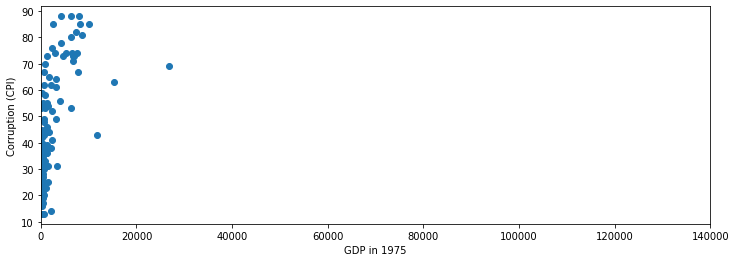

In [8]:
plot_cpi_against_gdp_for_year(joined_df, "1975", xmax=140000)

### Corruption perceptions index (CPI) versus GDP in 2021.

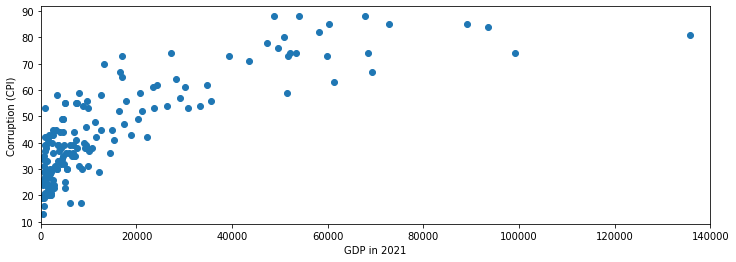

In [9]:
plot_cpi_against_gdp_for_year(joined_df, "2021", xmax=140000)

### Corruption perceptions index (CPI) versus change in GDP from 1975 to 2021. 

The CPI value is for the year 2021, so this is a backward-looking relationship. In this view of the data, we can't tell whether a country became less corrupt as its GDP grew. The relationship between the change in CPI and the change in GDP may be more informative.

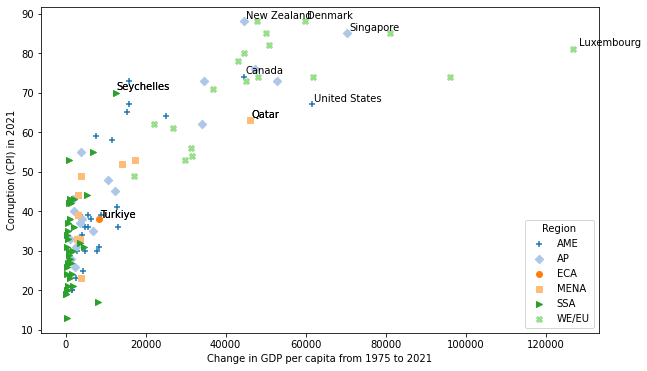

In [10]:
df_start_end, year_range_column = plot_cpi_against_change_in_gdp_per_capita(
    joined_df, "1975", "2021", annotate_extremes=True
)

### Tables of the extreme points labeled in the above plot.

In [11]:
columns = [GDP_COUNTRY_NAME, GDP_COUNTRY_CODE, CORRUPTION_INDEX, year_range_column, "Region"]
df_narrow = df_start_end[columns]

In [12]:
df_richest = get_top_countries_by_region(df_narrow, year_range_column)
df_richest

,Country Name,Country Code,CPI score 2021,1975-2021,Region
168,United States,USA,67,61486.079924,AME
140,Singapore,SGP,85,70304.091447,AP
163,Turkiye,TUR,38,8446.922425,ECA
133,Qatar,QAT,63,45983.424091,MENA
153,Seychelles,SYC,70,12500.492956,SSA
97,Luxembourg,LUX,81,126981.489543,WE/EU


In [13]:
df_least_corrupt = get_top_countries_by_region(df_narrow, CORRUPTION_INDEX)
df_least_corrupt

,Country Name,Country Code,CPI score 2021,1975-2021,Region
25,Canada,CAN,74,44540.140122,AME
122,New Zealand,NZL,88,44629.915388,AP
163,Turkiye,TUR,38,8446.922425,ECA
133,Qatar,QAT,63,45983.424091,MENA
153,Seychelles,SYC,70,12500.492956,SSA
43,Denmark,DNK,88,59803.934438,WE/EU


### Asia-Pacific

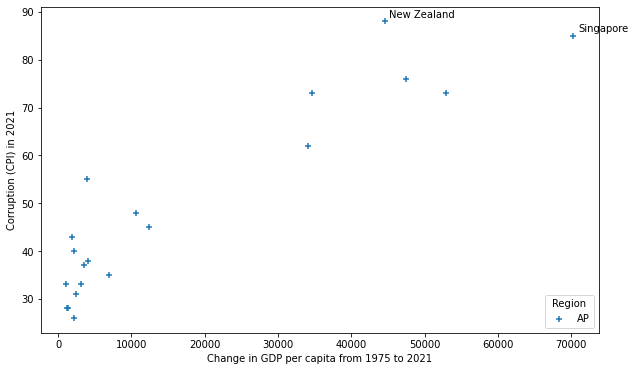

In [16]:
df_start_end, year_range_column = plot_cpi_against_change_in_gdp_per_capita(
    joined_df[joined_df.Region == "AP"],
    "1975",
    "2021",
    annotate_extremes=True
)

### Sub-Saharan Africa

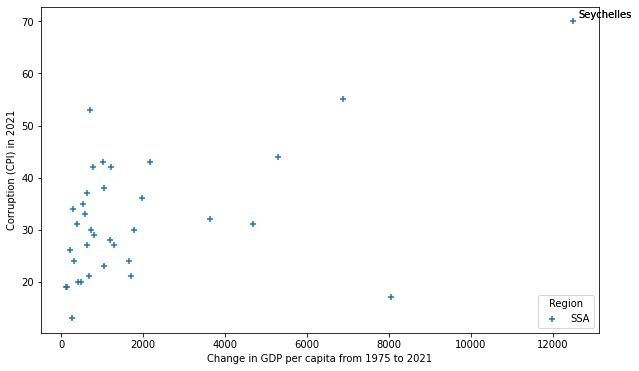

In [20]:
#@title Code
df_start_end, year_range_column = plot_cpi_against_change_in_gdp_per_capita(
    joined_df[joined_df.Region == "SSA"],
    "1975",
    "2021",
    annotate_extremes=True
)

Eastern and Central Asia

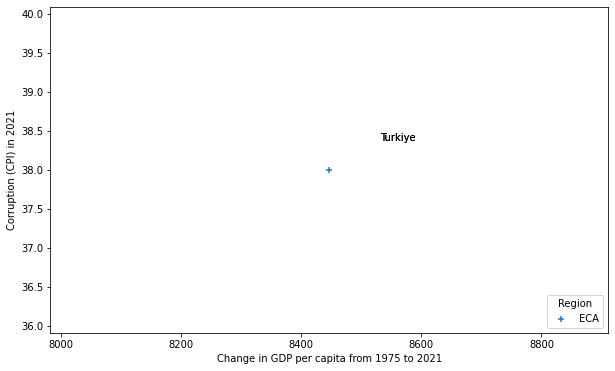

In [26]:
#@title Code
df_start_end, year_range_column = plot_cpi_against_change_in_gdp_per_capita(
    joined_df[joined_df.Region == "ECA"],
    "1975",
    "2021",
    annotate_extremes=True
)

### Middle East and North Africa

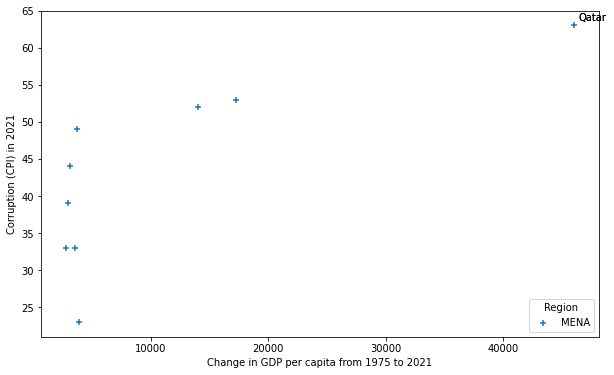

In [22]:
#@title Code
df_start_end, year_range_column = plot_cpi_against_change_in_gdp_per_capita(
    joined_df[joined_df.Region == "MENA"],
    "1975",
    "2021",
    annotate_extremes=True
)

### Americas

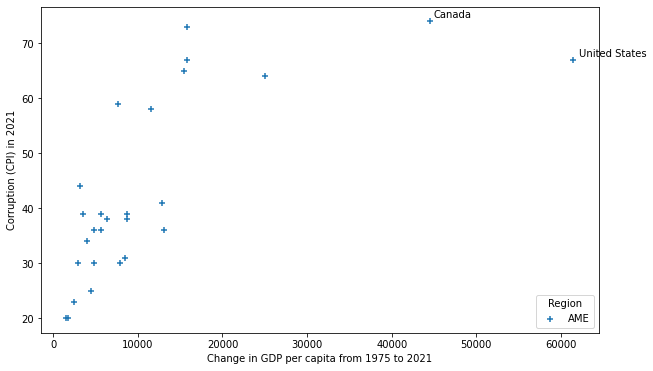

In [23]:
#@title Code
df_start_end, year_range_column = plot_cpi_against_change_in_gdp_per_capita(
    joined_df[joined_df.Region == "AME"],
    "1975",
    "2021",
    annotate_extremes=True
)

### Western Europe and European Union

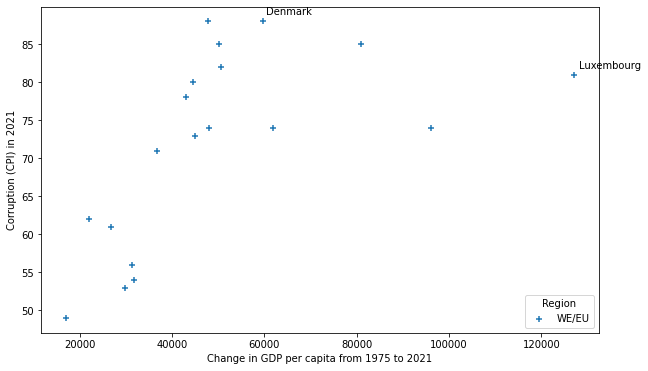

In [25]:
#@title Code
df_start_end, year_range_column = plot_cpi_against_change_in_gdp_per_capita(
    joined_df[joined_df.Region == "WE/EU"],
    "1975",
    "2021",
    annotate_extremes=True
)